In [280]:
# Attaching google drive

from google.colab import drive
drive.mount('/content/drive/')

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/refine-epitope-hmm/src')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [281]:
!pip install pomegranate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [282]:
from __future__ import print_function, division

import os, sys
import numpy as np
import pandas as pd
import pomegranate as pg
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, roc_curve


# Importing dataset to select exact epitopes and non-epitope

In [283]:
import pandas as pd 

ov_newdata = pd.read_csv('../input/Ov_newdata.csv')

In [284]:
list_exact = []
sequence=""
tipo=''
for index, row in ov_newdata.iterrows():
    if row['Info_type'] != 'NA':
      if row['Info_type']=='Exact Epitope':
        tipo = 'exact'
        sequence = sequence + row['Info_AA']
      else:        
        if tipo =='exact':
          tipo= 'noexact'
          list_exact.append(sequence)
          sequence=""

In [285]:
filted_list_exact = []
for l in list_exact:
  
  l_seq = list(l)
  if len(l_seq) > 7: 
    if len(l_seq) == 8:
        filted_list_exact.append(l)
    else:
        filted_list_exact.append(l[0:8])


In [286]:
ov_labelled_prots = pd.read_csv('../input/Ov_labelled_prots.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [287]:
list_non_epitope = []
sequence=""
tipo=''
for index, row in ov_labelled_prots.iterrows():
    if row['Class'] != 'NA':
      if row['Class']==-1:
        tipo = 'non-exact'
        sequence = sequence + row['Info_AA']
      else:        
        if tipo =='non-exact':
          tipo= 'exact'
          list_non_epitope.append(sequence)
          sequence=""


In [288]:
filted_list_non_epitope = []
for l in list_non_epitope:
  
  l_seq = list(l)
  if len(l_seq) > 7: 
    if len(l_seq) == 8:
      filted_list_non_epitope.append(l)
    else:
      filted_list_non_epitope.append(l[0:8])


In [289]:
#list_non_epitope_and_exact_epitope=  filted_list_non_epitope[0:50] + filted_list_exact[0:50]

## Calculating initial emission probabilities for the exact epitope

In [290]:
# Each sequence has 15 caracteres/columns
# There are 20 letters possible

import numpy

lists =[]

for seq in filted_list_exact:
  lists.append(list(seq))

matrix_exact = pd.DataFrame(lists)

In [291]:
emission_dic_exact = []

for col in matrix_exact.columns:
  emission_dic_exact.append((matrix_exact[col].value_counts()/matrix_exact[col].value_counts().sum()).to_dict())

In [292]:
import collections

rows = []

od_emission_dic_exact = []

for e in emission_dic_exact:
  od_emission_dic_exact.append(collections.OrderedDict(sorted(e.items())))

for e in od_emission_dic_exact:
  rows.append(e.values())
  
df_prob_per_position = pd.DataFrame(rows, columns = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']) 

emission_avg_epitope = dict()

for col in df_prob_per_position.columns:
  emission_avg_epitope[col] = df_prob_per_position[col].sum()/len(df_prob_per_position)

emission_avg_epitope

{'A': 0.06976010101010101,
 'C': 0.016098484848484848,
 'D': 0.061237373737373736,
 'E': 0.07891414141414141,
 'F': 0.039141414141414144,
 'G': 0.05934343434343434,
 'H': 0.017992424242424244,
 'I': 0.06849747474747475,
 'K': 0.05839646464646465,
 'L': 0.0836489898989899,
 'M': 0.021464646464646464,
 'N': 0.05366161616161616,
 'P': 0.06218434343434343,
 'Q': 0.05523989898989899,
 'R': 0.04861111111111111,
 'S': 0.0735479797979798,
 'T': 0.04797979797979798,
 'V': 0.049873737373737376,
 'W': 0.008522727272727274,
 'Y': 0.025883838383838384}

##Calculating initial emission probabilties for non-epitope

In [293]:
# Each sequence has 15 carcteres/columns
# There are 20 letters possible

import numpy

lists =[]
for seq in filted_list_non_epitope:
 
  lists.append(list(seq))

matrix_non_epitope = pd.DataFrame(lists)


In [294]:
non_epitope_emission_dic = []

for col in matrix_non_epitope.columns:
  non_epitope_emission_dic.append((matrix_non_epitope[col].value_counts()/matrix_non_epitope[col].value_counts().sum()).to_dict())


In [295]:
import collections

rows = []

# dictionary ordered
od_non_epitope_emission_dic = []

for e in non_epitope_emission_dic:
  od_non_epitope_emission_dic.append(collections.OrderedDict(sorted(e.items())))

for e in od_non_epitope_emission_dic:
  rows.append(e.values())
  
df_prob_per_position = pd.DataFrame(rows, columns = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']) 

emission_avg_non_epitope = dict()

for col in df_prob_per_position.columns:
  emission_avg_non_epitope[col] = df_prob_per_position[col].sum()/len(df_prob_per_position)


emission_avg_non_epitope

{'A': 0.05570409982174688,
 'C': 0.01693404634581105,
 'D': 0.06506238859180036,
 'E': 0.08333333333333334,
 'F': 0.03943850267379679,
 'G': 0.0659536541889483,
 'H': 0.020276292335115863,
 'I': 0.060160427807486636,
 'K': 0.07308377896613191,
 'L': 0.07308377896613191,
 'M': 0.02963458110516934,
 'N': 0.05102495543672014,
 'P': 0.05414438502673797,
 'Q': 0.04367201426024955,
 'R': 0.0481283422459893,
 'S': 0.0748663101604278,
 'T': 0.05325311942959002,
 'V': 0.05325311942959002,
 'W': 0.008467023172905526,
 'Y': 0.03052584670231729}

## Bulding a HMM - positive


In [296]:
# HMM parameters
numStates = 2
max_iterations = 5000    # max number of steps in Baum-Welch
stop_threshold = 0.0001 # log probability change cutoff in Baum-Welch

In [297]:
emission_probabilities = [emission_avg_non_epitope, emission_avg_epitope]

In [298]:
!apt-get install python-dev graphviz libgraphviz-dev pkg-config
!pip install pygraphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
pkg-config is already the newest version (0.29.1-0ubuntu2).
python-dev is already the newest version (2.7.15~rc1-1).
graphviz is already the newest version (2.40.1-2).
libgraphviz-dev is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [299]:
from pomegranate import *

d1 = DiscreteDistribution(emission_probabilities[0])
d2 = DiscreteDistribution(emission_probabilities[1])

e = State(d1, name="e")
n = State(d2, name="n")

model = HiddenMarkovModel('Epitope')

model.add_states([e, n])

model.add_transition(model.start, e, 0.1)
model.add_transition(model.start, n, 0.9)

model.add_transition(e, e, 0.9)
model.add_transition(e, n, 0.1)
model.add_transition(n, n, 0.9)
model.add_transition(n, e, 0.1)


#model.add_transition(e2, model.end, 0.1)


model.bake()

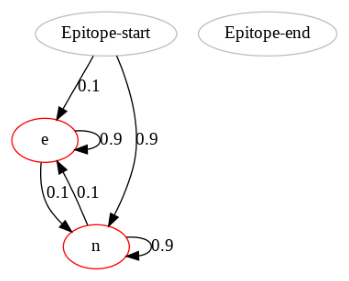

In [300]:
plt.figure(figsize=(6,6))

model.plot()

In [301]:
from sklearn.utils import shuffle

#Training

#Training set containing true exact epitopes
training_filted_list_exact = filted_list_exact[0:220]

#Training set containing non-epitopes
training_filted_list_non_epitope = filted_list_non_epitope[0:450]

#Combining training set containing true exact epitopes and non-epitopes
training =  training_filted_list_non_epitope + training_filted_list_exact
training_set_pg = [list(str(p)) for p in training]


#Testing

#Testing set containing true exact epitopes (40)
testing_filted_list_exact = filted_list_exact[231:271]

# Setting exact sequences to label 1
df_testing_filted_list_exact = pd.DataFrame(testing_filted_list_exact, columns = ['sequence']) 
df_testing_filted_list_exact['label'] = 1


#Testing set containing non-epitopes (120)
testing_filted_list_non_epitope = filted_list_non_epitope[451:571]
 
# Setting non-epitope to label 0
testing_filted_list_non_epitope = pd.DataFrame(testing_filted_list_non_epitope, columns = ['sequence']) 
testing_filted_list_non_epitope['label'] = 0

#Combining testing set containing true exact epitopes and non-epitopes

frames = [df_testing_filted_list_exact, testing_filted_list_non_epitope]

testing = pd.concat(frames)

testing = shuffle(testing)


In [302]:
#training_set_pg_positive = [list(str(p)) for p in training_filted_list_exact]

In [303]:
#%%time 

# train the model using Baum-Welch

model = model.fit(
    training_set_pg,
    algorithm = 'baum-welch',
    stop_threshold = stop_threshold,
    max_iterations = max_iterations,
    verbose = False,
    n_jobs = 4
)

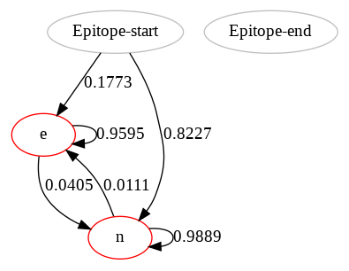

In [304]:
plt.figure(figsize=(6,6))

model.plot()

In [305]:
import pandas as pd

#QQIDPLDAEHSRGFV
#CVEEDMPEKVINDSQMTLRI
#IRRLINEESEEQKAV
#EVESGAAAAAAAAGQE
#CQPCPPGPPGP
#GGVFFEDGTRR
#WADDEWLKTVL
#QIEQQGSKNGK
#SMAAKKKKRNNMSRSRD
#AEEGSNGNVRE


sequences_containing_region = ['LLLLAITALEAGVVKRYNKRQQIDPLDAEHSRGFVCVEEDMPEKVINDSQMTLRI',
'GPDTNGSQFFICTECVEEDMPEKVINDSQMTLRILMDFDSRIKAYKFVSYAAVTFSTVA',
'GPPGPPGDAGPDGTPGQPGGVGAPGPVGPKGPPIRRLINEESEEQKAVQPGAPGVPGEKGICPKYCAIDGGVFFEDG',
'EKVLQAGFVPFGEIVSIEVESGAAAAAAAAGQEAAIDNMNDSELFGRTIRCN',
'YEGSHFHRIIPRFMVQGGDFTKGDGTGGKSIYGCQPCPPGPPGPFKLKHSMAGIVSMANCGPDTNGSQFFICTE',
'RQAYLLGGVFFEDGTRRLEVEDATRKLRLGDFMGNPDPAL',
'DASGKRLNTREIRKRQELEQLRHEKIQALLWADDEWLKTVLARCSNCGSDEHKT',
'NIVCTACGGAGHIAKDCKNPRQIEQQGSKNGKKPGLGSGSGGSGYKPKNYSLPSGTPI',
'GINSMAAKKKKRNNMSRSRDTDVPLYINAVFHESFIEVNEKGTEAAAASAVGIFLRSAPITLA',
'KSHSVPPEITGSSTPVCTTNVVFDGWEAEEGSNGNVREDEKITANYE']

df_sequences_containing_region = pd.DataFrame(columns = ['sequences_containing_region','sliced','position', 'probability', 'path'])

count=0;
for sequence_containing_region in sequences_containing_region:
  length_sequence_containing_region = len(sequence_containing_region)
  position=0;
  

  while position <= length_sequence_containing_region - 8:
    window = sequence_containing_region[position:position + 8]
    sliding_window = window
    window_likelihood = model.log_probability(list(str(sliding_window)))
    logp, path = model.viterbi(sliding_window)
    
    df_sequences_containing_region.loc[count] = [sequence_containing_region, window, position, window_likelihood, [state.name for idx, state in path]]
    position = position + 1;
    count = count + 1;


groupby_df_sequences_containing_region = df_sequences_containing_region.groupby(["sequences_containing_region"]).apply(lambda x: x).reset_index(drop=True)

groupby_df_sequences_containing_region['prediction'] = groupby_df_sequences_containing_region['path'].apply(lambda x: 1 if x[-2]=='e' else 0)


prob_best_sliding_window = groupby_df_sequences_containing_region.groupby(["sequences_containing_region"]).head(1)


groupby_df_sequences_containing_region



,sequences_containing_region,sliced,position,probability,path,prediction
0,LLLLAITALEAGVVKRYNKRQQIDPLDAEHSRGFVCVEEDMPEKVI...,LLLLAITA,0,-21.202241,"[Epitope-start, n, n, n, n, n, n, n, n]",0
1,LLLLAITALEAGVVKRYNKRQQIDPLDAEHSRGFVCVEEDMPEKVI...,LLLAITAL,1,-21.205327,"[Epitope-start, n, n, n, n, n, n, n, n]",0
2,LLLLAITALEAGVVKRYNKRQQIDPLDAEHSRGFVCVEEDMPEKVI...,LLAITALE,2,-21.099397,"[Epitope-start, n, n, n, n, n, n, n, n]",0
3,LLLLAITALEAGVVKRYNKRQQIDPLDAEHSRGFVCVEEDMPEKVI...,LAITALEA,3,-21.278736,"[Epitope-start, n, n, n, n, n, n, n, n]",0
4,LLLLAITALEAGVVKRYNKRQQIDPLDAEHSRGFVCVEEDMPEKVI...,AITALEAG,4,-21.924255,"[Epitope-start, n, n, n, n, n, n, n, n]",0
...,...,...,...,...,...,...
504,KSHSVPPEITGSSTPVCTTNVVFDGWEAEEGSNGNVREDEKITANYE,VREDEKIT,35,-21.950026,"[Epitope-start, n, n, n, n, n, n, n, n]",0
505,KSHSVPPEITGSSTPVCTTNVVFDGWEAEEGSNGNVREDEKITANYE,REDEKITA,36,-21.699589,"[Epitope-start, n, n, n, n, n, n, n, n]",0
506,KSHSVPPEITGSSTPVCTTNVVFDGWEAEEGSNGNVREDEKITANYE,EDEKITAN,37,-21.547980,"[Epitope-start, n, n, n, n, n, n, n, n]",0
507,KSHSVPPEITGSSTPVCTTNVVFDGWEAEEGSNGNVREDEKITANYE,DEKITANY,38,-22.788830,"[Epitope-start, n, n, n, n, n, n, n, n]",0


In [306]:
preds = []

for index, row in testing.iterrows():
  
  logp, path = model.viterbi(row['sequence'])
  last_state = [state.name for idx, state in path][-2]
  if last_state == 'e':
    preds.append(1)
  else:
    preds.append(0)

y_test = testing['label']



In [307]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_auc_score

print("ROC_AUC:", roc_auc_score(y_test, preds))

print(classification_report(y_test, preds))

ROC_AUC: 0.5511363636363636
              precision    recall  f1-score   support

           0       0.76      0.93      0.83       110
           1       0.47      0.17      0.25        40

    accuracy                           0.73       150
   macro avg       0.61      0.55      0.54       150
weighted avg       0.68      0.73      0.68       150

